#### Fashion MNIST - Image Classification

In this tutorial, we'll solve image classification problem using Fashion MNIST dataset. It consists of 28px by 28px grayscale images with labels (0 to 9).


In [2]:
# Import all necessary libraries and modules
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split, DataLoader

import torch.nn as nn
import torch.optim as optim

import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Creating dataset objects
dataset = FashionMNIST(root="/data", download=True, transform=transforms.ToTensor())
complete_ds = FashionMNIST(root="/data", train=True, transform=transforms.ToTensor()) # complete train dataset
test_ds = FashionMNIST(root="/data", train=False, transform=transforms.ToTensor()) # complete test dataset
len(complete_ds), len(test_ds)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



(60000, 10000)

In [5]:
train_ds, valid_ds = random_split(complete_ds, [50000, 10000])
len(train_ds), len(valid_ds), len(test_ds)

(50000, 10000, 10000)

In [6]:
# Creating the dataloader objects
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [7]:
X, y = train_ds[1]

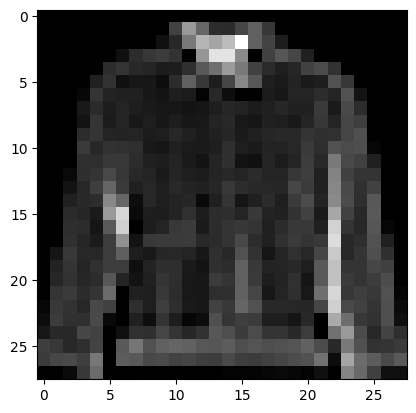

In [8]:
import matplotlib.pyplot as plt
plt.imshow(X.reshape(28,28), cmap='gray')

In [9]:
y #label

6

In [ ]:
# for (X, y) in iter(train_loader):
#     print(X, y)
#     break

In [10]:
X.shape # [channel, height, width]

torch.Size([1, 28, 28])

In [11]:
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

### Using GPUs

GPUs contain hundreds of cores optimized for performing extensive matrix operations.

In [12]:
X.device

device(type='cpu')

In [13]:
# move all my (X, y) to gpu - device cuda
# move all model and model parameters to gpu - cuda

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
X.device

device(type='cpu')

In [16]:
X = X.to(device)
X.device

device(type='cuda', index=0)

In [17]:
class customDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield [d.to(self.device) for d in b]

    def __len__(self):
        return len(self.dl)

In [18]:
train_loader = customDataLoader(train_loader, device)
test_loader = customDataLoader(test_loader, device)
valid_loader = customDataLoader(valid_loader, device)

In [19]:
class MLP(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(MLP, self).__init__()

        # layers
        # self.hidden = nn.Linear(in_size, hidden_size)
        # self.output = nn.Linear(hidden_size, out_size)
        # network
        self.network = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size)
        )

    def forward(self,x):
        xb = x.view(-1,784)
        # z1 = torch.relu(self.hidden(xb))
        # raw_preds = self.output(z1)
        raw_preds = self.network(xb)
        return raw_preds


In [20]:
model = MLP(784, 100, 10)
model.to(device)
ce_loss = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.001)

In [21]:
# raw_preds = model.forward(X)
# preds = torch.softmax(raw_preds, dim=1)
# max_val, pred_label = torch.max(preds, dim=1)
# max_val, pred_label

In [22]:
def evaluate(model, test_loader):
    correct = 0
    total = 0
    for (X, y) in iter(test_loader):
        raw_preds = model.forward(X)
        preds = torch.softmax(raw_preds, dim=1)
        max_val, pred_labels = torch.max(preds, dim=1)

        correct += (pred_labels==y).sum()
        total += len(X)
    return (correct/total)*100

In [23]:
%%time
res = pd.DataFrame()
for epoch in tqdm_notebook(range(50)):
    for (X, y) in iter(train_loader):
        raw_preds = model.forward(X) # forward
        loss = ce_loss(raw_preds, y) # loss
        loss.backward() # backward
        opt.step() # update weights and biases in the complete network
        opt.zero_grad()

    val_accuracy = evaluate(model, valid_loader)
    test_accuray = evaluate(model, test_loader)
    res = pd.concat([res, pd.DataFrame([[epoch, val_accuracy.item(), test_accuray.item()]])])


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 2min 33s, sys: 12.9 s, total: 2min 46s
Wall time: 7min 3s


In [27]:
# res.to_csv("./drive/MyDrive/files/res.csv")
res = pd.read_csv("./drive/MyDrive/files/res.csv")
res.drop(columns=res.filter(regex='Unnamed').columns.tolist(), inplace=True)
res.columns = ["epoch", "val_accuracy", "test_accuracy"]
res.head(10)

,epoch,val_accuracy,test_accuracy
0,0,27.299999,27.719997
1,1,45.009998,44.939999
2,2,53.459995,52.910000
3,3,59.439999,59.079998
4,4,62.040001,61.659996
5,5,64.029999,63.389999
6,6,65.050003,64.580002
7,7,65.989998,65.070000
8,8,66.819992,65.889999
9,9,67.629997,66.549995


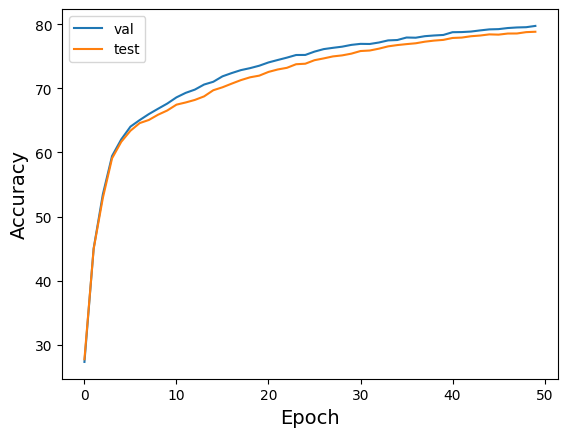

In [26]:
fig, ax = plt.subplots()
ax.plot(res["epoch"], res["val_accuracy"], label="val")
ax.plot(res["epoch"], res["test_accuracy"], label="test")
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Accuracy", size=14)
ax.legend()
plt.show()

### Hyper Parameter Tuning

In [28]:
hyper_param_grid = {
    "lr": [0.001, 0.0001, 0.00001],
    "batch_size": [32, 64, 128],
}

In [29]:
keys, values = zip(*hyper_param_grid.items())
keys, values

(('lr', 'batch_size'), ([0.001, 0.0001, 1e-05], [32, 64, 128]))

In [30]:
# cartesian product of all these hyper parameters as stated above
import itertools
params = [dict(zip(keys, v)) for v in itertools.product(*values)]
params

[{'lr': 0.001, 'batch_size': 32},
 {'lr': 0.001, 'batch_size': 64},
 {'lr': 0.001, 'batch_size': 128},
 {'lr': 0.0001, 'batch_size': 32},
 {'lr': 0.0001, 'batch_size': 64},
 {'lr': 0.0001, 'batch_size': 128},
 {'lr': 1e-05, 'batch_size': 32},
 {'lr': 1e-05, 'batch_size': 64},
 {'lr': 1e-05, 'batch_size': 128}]

In [ ]:
%%time
res = pd.DataFrame()

for param in params:
    train_loader = DataLoader(train_ds, batch_size=param["batch_size"], shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_ds, batch_size=param["batch_size"])
    test_loader = DataLoader(test_ds, batch_size=param["batch_size"])

    train_loader = customDataLoader(train_loader, device)
    test_loader = customDataLoader(test_loader, device)
    valid_loader = customDataLoader(valid_loader, device)

    model = MLP(784, 100, 10)
    model.to(device)
    ce_loss = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr=0.001)

    for epoch in tqdm_notebook(range(2)):
        for (X, y) in iter(train_loader):
            raw_preds = model.forward(X) # forward
            loss = ce_loss(raw_preds, y) # loss
            loss.backward() # backward
            opt.step() # update weights and biases in the complete network
            opt.zero_grad()

    train_accuracy = evaluate(model, train_loader)
    val_accuracy = evaluate(model, valid_loader)
    test_accuray = evaluate(model, test_loader)
    res = pd.concat([res, pd.DataFrame([[param, epoch, train_accuracy.item(), val_accuracy.item(), test_accuray.item()]])])

res.columns = ["param", "epoch", "train_accuracy", "val_accuracy", "test_accuracy"]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 12.2 s, total: 1min 22s
Wall time: 4min 3s


In [ ]:
res.sort_values(by="val_accuracy", asending=False)